In [2]:
'''
learning_erddap-python_dev-v5.ipynb
@author TEJ
@date 2023-02-23
'''
import numpy as np
import pandas as pd 
import xarray as xr
import netCDF4 as nc
import datetime as dt
from matplotlib import pyplot as plt 
import seaborn as sns
import urllib.request
import datetime

import erddapClient as erd


In [3]:
#defining palettes

#               black    purple     blue        cyan       green    chartreuse  orange     red
#                         412       443         490         510        555       620        683
colors_black = ["00000","#7b00e2", "#001bff", "#00ffff", "#00ff00", "#b3ff00", "#ff7700", "#ff0000"]
pal_black = sns.color_palette(colors_black)

colors = ["#7b00e2", "#001bff", "#00ffff", "#00ff00", "#b3ff00", "#ff7700", "#ff0000"]
pal = sns.color_palette(colors)


colors_r = ["#ff0000", "#ff7700", "#b3ff00", "#00ff00", "#00ffff", "#001bff", "#7b00e2"]
pal_r = sns.color_palette(colors_r)

In [4]:
#defining relevant lists (for iteration)
wavelengthnm_list = ["spectir_412nm","spectir_443nm","spectir_490nm","spectir_510nm","spectir_555nm","spectir_620nm","spectir_683nm"]
wavelength_list_int = [413,443,490,510,555,620,683]
wavelength_list = ["412","443","490","510","555","620","683"]
wavelengthqc_agg_list = ["spectir_412nm_qc_agg","spectir_443nm_qc_agg","spectir_490nm_qc_agg","spectir_510nm_qc_agg","spectir_555nm_qc_agg","spectir_620nm_qc_agg","spectir_683nm_qc_agg"]
mooring_list = ["or_inshore", "or_shelf","wa_inshore","wa_shelf"]
data_id_list = ["ooi-ce01issp-sp001-07-spkirj000", "ooi-ce02shsp-sp001-06-spkirj000", 
                "ooi-ce06issp-sp001-07-spkirj000", "ooi-ce07shsp-sp001-06-spkirj000"]

In [5]:
#read in 8 filtered datasets using pandas
or_inshore_fails=pd.read_csv("{}_fails.csv".format(mooring_list[0]))
or_shelf_fails=pd.read_csv("{}_fails.csv".format(mooring_list[1]))
wa_inshore_fails=pd.read_csv("{}_fails.csv".format(mooring_list[2]))
wa_shelf_fails=pd.read_csv("{}_fails.csv".format(mooring_list[3]))

or_inshore_nans=pd.read_csv("{}_nans.csv".format(mooring_list[0]))
or_shelf_nans=pd.read_csv("{}_nans.csv".format(mooring_list[1]))
wa_inshore_nans=pd.read_csv("{}_nans.csv".format(mooring_list[2]))
wa_shelf_nans=pd.read_csv("{}_nans.csv".format(mooring_list[3]))

In [185]:
#altering time col                                           everyrow,o=0th col
#(pandas:)or_inshore_fails["time"] vs (numpy:)or_inshore_fails_np[ :,0]
or_inshore_fails["time"] = pd.to_datetime(or_inshore_fails["time"])
or_shelf_fails["time"] = pd.to_datetime(or_shelf_fails["time"])
wa_inshore_fails["time"] = pd.to_datetime(wa_inshore_fails["time"])
wa_shelf_fails["time"] = pd.to_datetime(wa_shelf_fails["time"])

or_inshore_nans["time"] = pd.to_datetime(or_inshore_nans["time"])
or_shelf_nans["time"] = pd.to_datetime(or_shelf_nans["time"])
wa_inshore_nans["time"] = pd.to_datetime(wa_inshore_nans["time"])
wa_shelf_nans["time"] = pd.to_datetime(wa_shelf_nans["time"])

In [173]:
wa_shelf_nans.time[1]

Timestamp('2015-04-09 23:25:00+0000', tz='UTC')

In [227]:
#numpy kick: i am abandoning bc plotting it happier w pandas????
# i am returning to the numpy which lets us make netcdfs
#creating dtype tuples for naming cols within arrays and assigning data type

dtype = [('time', "np.datetime64"), ('depth', 'float64'), ('wavelength', 'str'), ('spectir','float64')]
#array = np.array(arraylist, dtype=dtype)
or_inshore_fails_np = np.array(or_inshore_fails)#,dtype=dtype)
or_shelf_fails_np = or_shelf_fails.to_numpy()
wa_inshore_fails_np = wa_inshore_fails.to_numpy()
wa_shelf_fails_np = wa_shelf_fails.to_numpy()

or_inshore_nans_np = or_inshore_nans.to_numpy()
or_shelf_nans_np = or_shelf_nans.to_numpy()
wa_inshore_nans_np = wa_inshore_nans.to_numpy()
wa_shelf_nans_np = wa_shelf_nans.to_numpy()
or_inshore_nans_np[:,0]

array([Timestamp('2014-04-17 22:28:00+0000', tz='UTC'),
       Timestamp('2014-04-17 22:28:00+0000', tz='UTC'),
       Timestamp('2014-04-17 22:28:00+0000', tz='UTC'), ...,
       Timestamp('2022-09-27 07:53:00+0000', tz='UTC'),
       Timestamp('2022-09-27 07:53:00+0000', tz='UTC'),
       Timestamp('2022-09-27 07:53:00+0000', tz='UTC')], dtype=object)

In [200]:
or_inshore_fails_np[:,0] = or_inshore_fails_np[:,0].astype("datetime64")
or_shelf_fails_np[:,0] = or_shelf_fails_np[:,0].astype("datetime64")
wa_inshore_fails_np[:,0] = wa_inshore_fails_np[:,0].astype("datetime64")
wa_shelf_fails_np[:,0] = wa_shelf_fails_np[:,0].astype("datetime64")

or_shelf_nans_np[:,0] = or_shelf_nans_np[:,0].astype("datetime64")
or_inshore_nans_np[:,0] = or_inshore_nans_np[:,0].astype("datetime64")
wa_shelf_nans_np[:,0] = wa_shelf_nans_np[:,0].astype("datetime64")
wa_inshore_nans_np[:,0] = wa_inshore_nans_np[:,0].astype("datetime64")

<ipython-input-200-455f9347f400>:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  or_shelf_fails_np[:,0] = or_shelf_fails_np[:,0].astype("datetime64")
<ipython-input-200-455f9347f400>:3: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  wa_inshore_fails_np[:,0] = wa_inshore_fails_np[:,0].astype("datetime64")
<ipython-input-200-455f9347f400>:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  wa_shelf_fails_np[:,0] = wa_shelf_fails_np[:,0].astype("datetime64")
<ipython-input-200-455f9347f400>:6: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  or_shelf_nans_np[:,0] = or_shelf_nans_np[:,0].astype("datetime64")
<ipython-input-200-455f9347f400>:7: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future

In [210]:
#unnamed array?
fails_array = np.array([or_inshore_fails_np, 
                        or_shelf_fails_np,
                        wa_inshore_fails_np,
                        wa_shelf_fails_np],dtype=object)

In [212]:
#dictionary?
fails_array = {'or_inshore_fails_np':or_inshore_fails_np, 
               'or_shelf_fails_np':or_shelf_fails_np,
               "wa_inshore_fails_np":wa_inshore_fails_np,
               'wa_shelf_fails_np':wa_shelf_fails_np
              }

In [208]:
fails_array['or_inshore_fails_np'][:,0]

array([datetime.datetime(2015, 9, 17, 20, 12),
       datetime.datetime(2015, 9, 18, 8, 12),
       datetime.datetime(2015, 9, 18, 14, 6),
       datetime.datetime(2016, 7, 26, 14, 24),
       datetime.datetime(2016, 8, 1, 8, 25),
       datetime.datetime(2016, 9, 30, 8, 9),
       datetime.datetime(2017, 5, 25, 14, 2),
       datetime.datetime(2017, 5, 30, 20, 5),
       datetime.datetime(2017, 9, 18, 19, 55),
       datetime.datetime(2017, 9, 30, 19, 59),
       datetime.datetime(2017, 10, 5, 19, 59),
       datetime.datetime(2018, 6, 21, 14, 9),
       datetime.datetime(2018, 7, 7, 8, 12),
       datetime.datetime(2019, 6, 29, 2, 19),
       datetime.datetime(2019, 6, 30, 2, 20),
       datetime.datetime(2019, 7, 3, 8, 3),
       datetime.datetime(2019, 7, 21, 20, 3),
       datetime.datetime(2020, 9, 14, 20, 12),
       datetime.datetime(2020, 9, 19, 20, 12),
       datetime.datetime(2015, 9, 17, 20, 12),
       datetime.datetime(2015, 9, 18, 8, 12),
       datetime.datetime(2015, 

In [213]:
stu_datetime = fails_array['or_inshore_fails_np'][:,0][1][:-1] #yea stu just substringselect every row stu
#stopped working hwne convered from string to datetime. no wroroies anymore stu
stu_datetime #no 
np.datetime64(stu_datetime)

TypeError: 'datetime.datetime' object is not subscriptable

In [221]:
fails_xr = xr.DataArray(fails_array)
fails_xr

<xarray.DataArray ()>
array(<built-in method values of dict object at 0x7fb70e5f7dc0>,
      dtype=object)

In [214]:
nans_array = np.array([or_inshore_nans_np, 
                        or_shelf_nans_np,
                        wa_inshore_nans_np,
                        wa_shelf_nans_np],dtype=object)

In [215]:
b = np.datetime64('2005-02-25')
b

numpy.datetime64('2005-02-25')

In [218]:
#try ooi method below. feb 28

In [217]:
lat = np.arange(-90, 91, 1)
lon = np.arange(-180, 181, 1)
time = np.arange(0, 365, 1)
data1 = np.random.rand(len(time), len(lat), len(lon))

In [ ]:
#from chat gcpt
import numpy as np
from netCDF4 import Dataset

# Define the dimensions of the arrays
lat = np.arange(-90, 91, 1)
lon = np.arange(-180, 181, 1)
time = np.arange(0, 365, 1)

# Define the data arrays
data1 = np.random.rand(len(time), len(lat), len(lon))
data2 = np.random.rand(len(time), len(lat))
data3 = np.random.rand(len(lat), len(lon))

# Create a new NetCDF file
with Dataset('output.nc', 'w') as ncfile:

    # Define the dimensions in the NetCDF file
    ncfile.createDimension('lat', len(lat))
    ncfile.createDimension('lon', len(lon))
    ncfile.createDimension('time', len(time))

    # Define the variables and their dimensions in the NetCDF file
    lat_var = ncfile.createVariable('lat', np.float32, ('lat',))
    lon_var = ncfile.createVariable('lon', np.float32, ('lon',))
    time_var = ncfile.createVariable('time', np.int32, ('time',))
    data1_var = ncfile.createVariable('data1', np.float32, ('time', 'lat', 'lon',))
    data2_var = ncfile.createVariable('data2', np.float32, ('time', 'lat',))
    data3_var = ncfile.createVariable('data3', np.float32, ('lat', 'lon',))

    # Write the data to the NetCDF file
    lat_var[:] = lat
    lon_var[:] = lon
    time_var[:] = time
    data1_var[:] = data1
    data2_var[:] = data2
    data3_var[:] = data3


Spectral Irradiance by Depth for or_inshore_fails n=133


# plotting ventures

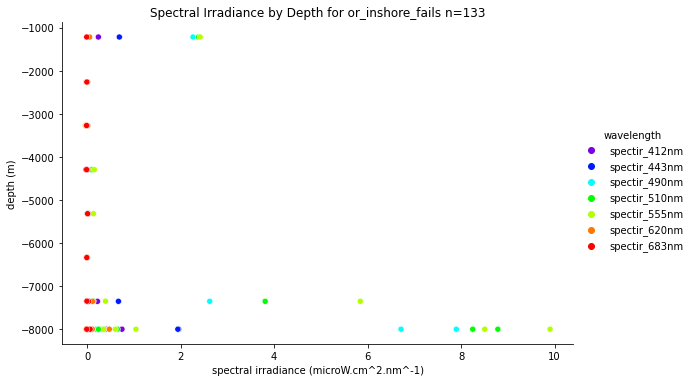

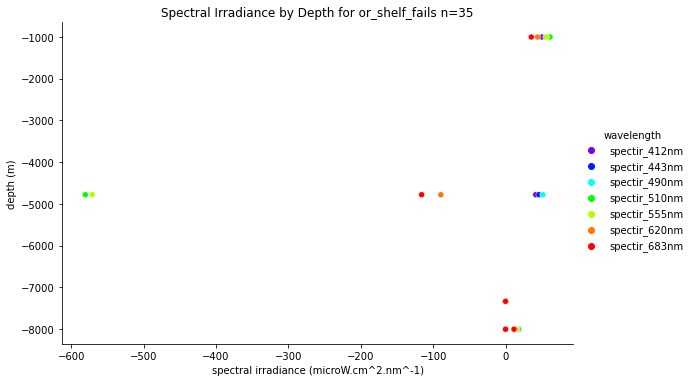

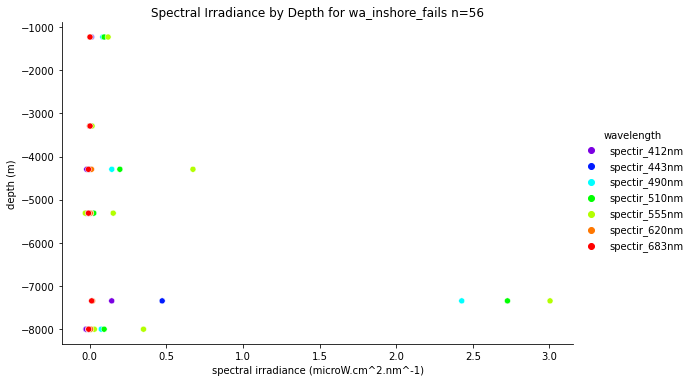

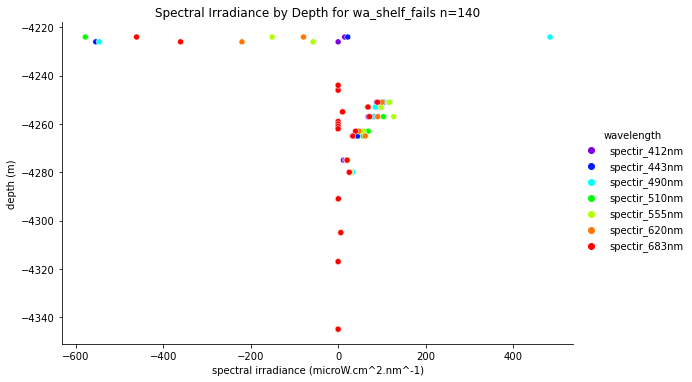

In [98]:
#plotting spectral irradiance by depth: see outliers
#first for the fails

sns.relplot(data=or_inshore_fails, x='spectir', y='z', hue='wavelength', 
            hue_order=wavelengthnm_list, palette = pal, aspect=1.61)

plt.xlabel("spectral irradiance (microW.cm^2.nm^-1)")
plt.ylabel("depth (m)")
plt.title("Spectral Irradiance by Depth for or_inshore_fails n={}".format(len(or_inshore_fails)))
plt.savefig("fails_or_inshore_spectir_scatter.png", dpi=600)
plt.show()

sns.relplot(data=or_shelf_fails, x='spectir', y='z', hue='wavelength', 
            hue_order=wavelengthnm_list, palette = pal, aspect=1.61)
plt.xlabel("spectral irradiance (microW.cm^2.nm^-1)")
plt.ylabel("depth (m)")
plt.title("Spectral Irradiance by Depth for or_shelf_fails n={}".format(len(or_shelf_fails)))
plt.savefig("fails_or_shelf_spectir_scatter.png", dpi=600)
plt.show()

sns.relplot(data=wa_inshore_fails, x='spectir', y='z', hue='wavelength', 
            hue_order=wavelengthnm_list, palette = pal, aspect=1.61)
plt.xlabel("spectral irradiance (microW.cm^2.nm^-1)")
plt.ylabel("depth (m)")
plt.title("Spectral Irradiance by Depth for wa_inshore_fails n={}".format(len(wa_inshore_fails)))
plt.savefig("fails_wa_inshore_spectir_scatter.png", dpi=600)
plt.show()

sns.relplot(data=wa_shelf_fails, x='spectir', y='z', hue='wavelength', 
            hue_order=wavelengthnm_list, palette = pal, aspect=1.61)
plt.xlabel("spectral irradiance (microW.cm^2.nm^-1)")
plt.ylabel("depth (m)")
plt.title("Spectral Irradiance by Depth for wa_shelf_fails n={}".format(len(wa_shelf_fails)))
plt.savefig("fails_wa_shelf_spectir_scatter.png", dpi=600)
plt.show()

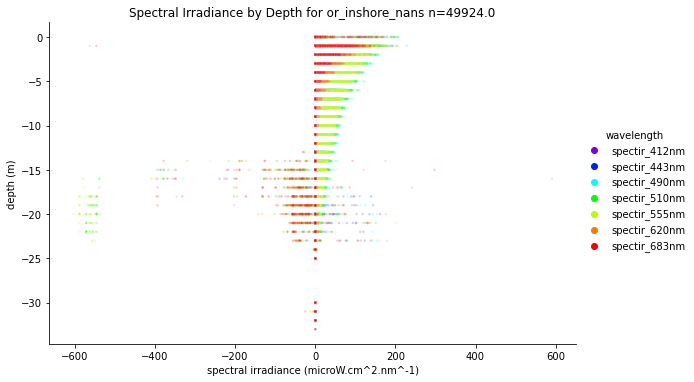

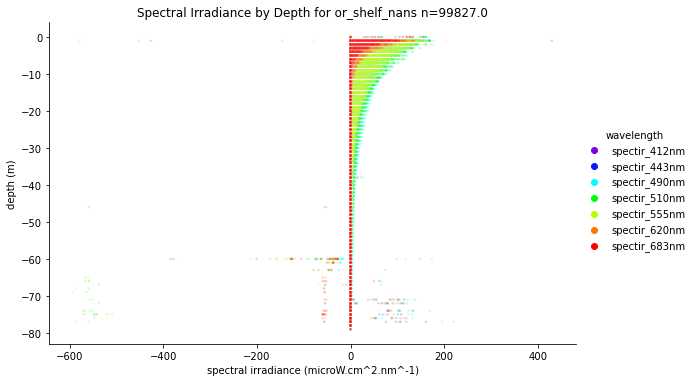

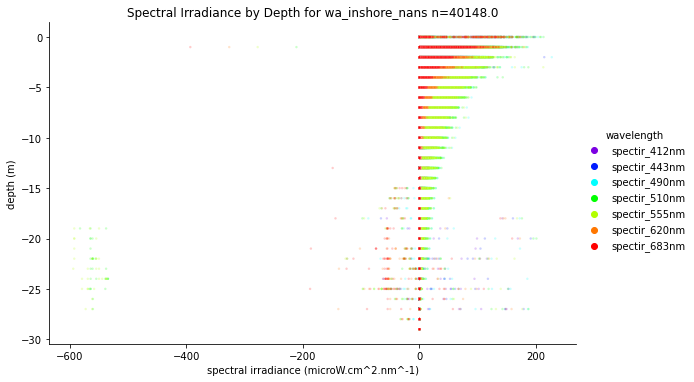

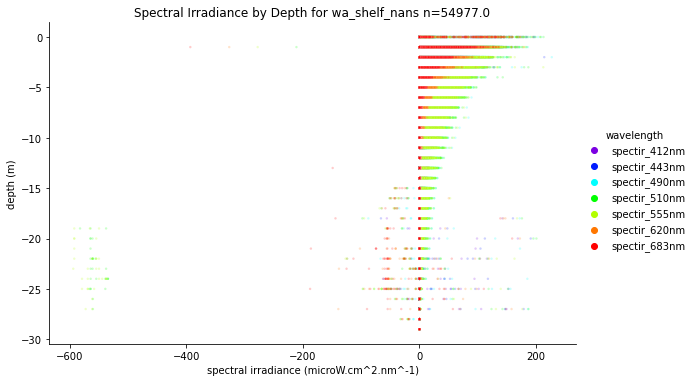

In [97]:
#spectral irradiance by depth for nans: heftier datasets
sns.relplot(data=or_inshore_nans, x='spectir', y='z', 
            hue='wavelength', hue_order=wavelengthnm_list, palette = pal, aspect=1.61, 
            s=6, edgecolors=None, alpha = 0.2)
plt.xlabel("spectral irradiance (microW.cm^2.nm^-1)")
plt.ylabel("depth (m)")
plt.title("Spectral Irradiance by Depth for or_inshore_nans n={}".format(len(or_inshore_nans)/7))
plt.savefig("nans_or_inshore_spectir_scatter.png", dpi=600)
plt.show()

sns.relplot(data=or_shelf_nans, x='spectir', y='z', 
            hue='wavelength', hue_order=wavelengthnm_list, palette = pal, aspect=1.61,
            s=6, edgecolors=None, alpha = 0.2)
plt.xlabel("spectral irradiance (microW.cm^2.nm^-1)")
plt.ylabel("depth (m)")
plt.title("Spectral Irradiance by Depth for or_shelf_nans n={}".format(len(or_shelf_nans)/7))
plt.savefig("nans_or_shelf_spectir_scatter.png", dpi=600)
plt.show()

sns.relplot(data=wa_inshore_nans, x='spectir', y='z', 
            hue='wavelength', hue_order=wavelengthnm_list, palette = pal, aspect=1.61,
            s=6, edgecolors=None, alpha = 0.2)
plt.xlabel("spectral irradiance (microW.cm^2.nm^-1)")
plt.ylabel("depth (m)")
plt.title("Spectral Irradiance by Depth for wa_inshore_nans n={}".format(len(wa_inshore_nans)/7))
plt.savefig("nans_wa_inshore_spectir_scatter.png", dpi=600)
plt.show()

sns.relplot(data=wa_inshore_nans, x='spectir', y='z', 
            hue='wavelength', hue_order=wavelengthnm_list, palette = pal, aspect=1.61,
            s=6, edgecolors=None, alpha = 0.2)
plt.xlabel("spectral irradiance (microW.cm^2.nm^-1)")
plt.ylabel("depth (m)")
plt.title("Spectral Irradiance by Depth for wa_shelf_nans n={}".format(len(wa_shelf_nans)/7))
plt.savefig("nans_wa_shelf_spectir_scatter.png", dpi=600)
plt.show()

KeyboardInterrupt: 

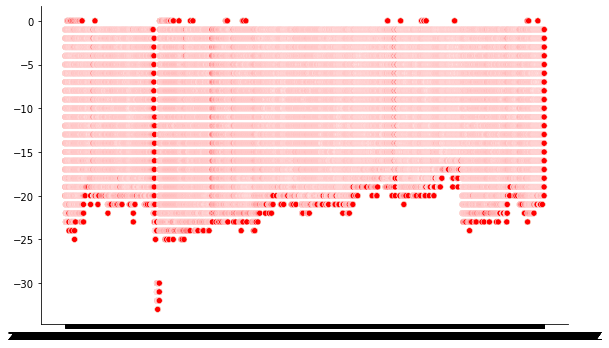

In [20]:
#trying to plot z by time
#i think unsuccessful sofar bc. of treatment of time axis in timestamp which is bad
sns.relplot(data=or_inshore_nans, x='time', y='z', hue='wavelength', hue_order=wavelengthnm_list, palette = pal, aspect=1.61)
plt.xlabel("time")
plt.ylabel("depth (z)")
plt.title("z by time(Timestamp) for or_inshore_nans")
plt.show()

sns.relplot(data=or_shelf_nans, x='time', y='z', hue='wavelength', hue_order=wavelengthnm_list, palette = pal, aspect=1.61)
plt.xlabel("time")
plt.ylabel("depth (z)")
plt.title("z by time(Timestamp) for or_shelf_nans")

plt.show()

sns.relplot(data=wa_inshore_nans, x='time', y='z', hue='wavelength', hue_order=wavelengthnm_list, palette = pal, aspect=1.61)
plt.xlabel("time")
plt.ylabel("depth (z)")
plt.title("z by time(Timestamp) by Depth for wa_inshore_nans")
plt.show()

sns.relplot(data=wa_inshore_nans, x='time', y='z', hue='wavelength', hue_order=wavelengthnm_list, palette = pal, aspect=1.61)
plt.xlabel("time")
plt.ylabel("depth (z)")
plt.title("z by time(Timestamp) by Depth for wa_shelf_nans")
plt.xlim(Timestamp(2017))
plt.show()

this is not very nice. date is it TimeStamp form which people think is bad. I will try to convert to pd datetime

see below 3/2

In [175]:
or_inshore_fails['time'].min()

Timestamp('2015-09-17 20:12:00+0000', tz='UTC')

NameError: name 'fails_array' is not defined

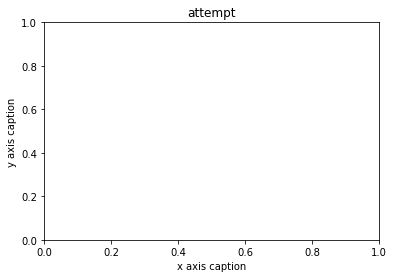

In [21]:
plt.title("attempt") 
plt.xlabel("x axis caption") 
plt.ylabel("y axis caption") 
plt.plot(fails_array['or_inshore_fails_np'][:,0],fails_array['or_inshore_fails_np'][:,1]) 
plt.show() 

# 28 feb 
lets do itttt
https://github.com/ooi-data-review/2018-data-workshops/blob/master/chemistry/examples/quickstart_python.ipynb

retrieve multiple datasets at once? merge netcdfs? slay

In [29]:
import requests
import os
import re

!pip install netcdf4 
!pip install dask
!pip install xarray
import xarray as xr

import matplotlib.pyplot as plt

In [27]:
API_USERNAME = 'OOIAPI-CW7R6SO6XQ1FXJ'
API_TOKEN = 'TEMP-TOKEN-JRRU4IA04CGLH4'

In [39]:
SENSOR_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'
r = requests.get(SENSOR_BASE_URL, auth=(API_USERNAME, API_TOKEN))
print( r.status_code) #this means status: good
print( r.headers )
print( r.encoding )
print( r.text )
#print( r.json() )

200
{'Server': 'nginx', 'Date': 'Thu, 02 Mar 2023 17:07:00 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Strict-Transport-Security': 'max-age=63072000', 'X-Frame-Options': 'SAMEORIGIN', 'X-XSS-Protection': '1; mode=block'}
utf-8
[ "CE01ISSM", "CE01ISSP", "CE02SHBP", "CE02SHSM", "CE02SHSP", "CE04OSBP", "CE04OSPD", "CE04OSPI", "CE04OSPS", "CE04OSSM", "CE05MOAS", "CE06ISSM", "CE06ISSP", "CE07SHSM", "CE07SHSP", "CE09OSPM", "CE09OSSM", "CP01CNPM", "CP01CNSM", "CP01CNSP", "CP02PMCI", "CP02PMCO", "CP02PMUI", "CP02PMUO", "CP03ISPM", "CP03ISSM", "CP03ISSP", "CP04OSPM", "CP04OSSM", "CP05MOAS", "GA01SUMO", "GA02HYPM", "GA03FLMA", "GA03FLMB", "GA05MOAS", "GI01SUMO", "GI02HYPM", "GI03FLMA", "GI03FLMB", "GI05MOAS", "GP02HYPM", "GP03FLMA", "GP03FLMB", "GP05MOAS", "GS01SUMO", "GS02HYPM", "GS03FLMA", "GS03FLMB", "GS05MOAS", "RS01OSBP", "RS01SBPD", "RS01SBPS", "RS01SHBP", "RS01SHDR", "RS01SLBS", "RS01SUM1", "RS01SUM2", "RS03ASHS", "RS03AXBS", "RS0

In [ ]:
# A quick function to make an API request and print the results
def get_and_print_api(url):
  r = requests.get(url, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  for d in data:
    print( d )

In [47]:
#now tunneling into API directories
#for use in determining path for request
print("node:")
get_and_print_api(SENSOR_BASE_URL+'/CE01ISSP')
print("\n")
print("sensors:")
get_and_print_api(SENSOR_BASE_URL+'/CE01ISSP/SP001')
print("\n")
print("methods:")
get_and_print_api(SENSOR_BASE_URL+'/CE01ISSP/SP001/07-SPKIRJ000')
print("\n")
print("data streams: ")
get_and_print_api(SENSOR_BASE_URL+'/CE01ISSP/SP001/07-SPKIRJ000/recovered_cspp/')

node:
SP001


sensors:
00-SPPENG000
02-DOSTAJ000
04-OPTAAJ000
05-VELPTJ000
06-NUTNRJ000
07-SPKIRJ000
08-FLORTJ000
09-CTDPFJ000
10-PARADJ000


methods:
recovered_cspp


data streams: 
spkir_abj_cspp_instrument_recovered
spkir_abj_cspp_metadata_recovered


In [50]:
# my instrument
#these variables are CASE SENSITIVE
site = 'CE01ISSP'
node = 'SP001'
instrument = '07-SPKIRJ000'
method = 'recovered_cspp'
stream = 'spkir_abj_cspp_instrument_recovered'

api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'

# Create the request URL
data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))
     
params = {
  'format':'application/netcdf',

}
#synchronous: json smaller
#asynchronous: netcdf bigger

#example Instrument Information
site = 'CP04OSSM'
node = 'SBD11'
instrument = '06-METBKA000'
method = 'telemetered'
stream = 'metbk_a_dcl_instrument'

api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'

#Create the request URL
data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

#another example thing
#Instrument Information
site = 'GP03FLMB'
node = 'RIM01'
instrument = '02-CTDMOG060'
method = 'telemetered'
stream = 'ctdmo_ghqr_sio_mule_instrument'

data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))

params = {
  'beginDT':'2016-10-01T00:00:00.000Z',
  'endDT':'2016-11-01T00:00:00.000Z',
  'limit':1000,   
}

In [33]:
#doing synchronous request
r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
data = r.json()
data

{'requestUUID': 'bf8ec45a-b6c3-4162-8eb0-c56e6c09f0ce',
 'outputURL': 'https://opendap-west.oceanobservatories.org/thredds/catalog/ooi/turner.e.johnson@gmail.com/20230302T170338874Z-CE01ISSP-SP001-07-SPKIRJ000-recovered_cspp-spkir_abj_cspp_instrument_recovered/catalog.html',
 'allURLs': ['https://opendap-west.oceanobservatories.org/thredds/catalog/ooi/turner.e.johnson@gmail.com/20230302T170338874Z-CE01ISSP-SP001-07-SPKIRJ000-recovered_cspp-spkir_abj_cspp_instrument_recovered/catalog.html',
  'https://downloads-west.oceanobservatories.org/async_results/turner.e.johnson@gmail.com/20230302T170338874Z-CE01ISSP-SP001-07-SPKIRJ000-recovered_cspp-spkir_abj_cspp_instrument_recovered'],
 'sizeCalculation': 147021169,
 'timeCalculation': 60,
 'numberOfSubJobs': 1543}

In [51]:
requests.get(data['allURLs'][1] + '/status.txt')

<Response [200]>

In [53]:
#from allURLs above
url = 'https://opendap-west.oceanobservatories.org/thredds/catalog/ooi/turner.e.johnson@gmail.com/20230301T044607127Z-CE01ISSP-SP001-07-SPKIRJ000-recovered_cspp-spkir_abj_cspp_instrument_recovered/catalog.html'

In [54]:
#finding all nc directories
#each one corresponds with a "deployment"
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/turner.e.johnson@gmail.com/20230301T044607127Z-CE01ISSP-SP001-07-SPKIRJ000-recovered_cspp-spkir_abj_cspp_instrument_recovered/deployment0020_CE01ISSP-SP001-07-SPKIRJ000-recovered_cspp-spkir_abj_cspp_instrument_recovered_20220715T193449.710000-20220927T075331.181000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/turner.e.johnson@gmail.com/20230301T044607127Z-CE01ISSP-SP001-07-SPKIRJ000-recovered_cspp-spkir_abj_cspp_instrument_recovered/deployment0019_CE01ISSP-SP001-07-SPKIRJ000-recovered_cspp-spkir_abj_cspp_instrument_recovered_20220415T220006.567000-20220516T122054.930000.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/turner.e.johnson@gmail.com/20230301T044607127Z-CE01ISSP-SP001-07-SPKIRJ000-recovered_cspp-spkir_abj_cspp_instrument_recovered/deployment0018_CE01ISSP-SP001-07-SPKIRJ000-recovered_cspp-spkir_abj_cspp_instrument_recovered_20210629T162451.397000-20210711T080402.840000.nc',
 'https://

In [295]:
len(datasets) #number of "deploymnets"

20

In [138]:
ds = xr.open_mfdataset(datasets[15:20])
ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
ds = ds.chunk({'time': 100}) # Used for optimization
ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
ds

<xarray.Dataset>
Dimensions:                            (spectra: 7, time: 62894)
Coordinates:
    obs                                (time) int64 dask.array<chunksize=(100,), meta=np.ndarray>
    lat                                (time) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    lon                                (time) float64 dask.array<chunksize=(100,), meta=np.ndarray>
  * spectra                            (spectra) int32 0 1 2 3 4 5 6
    depth                              (time) float64 dask.array<chunksize=(100,), meta=np.ndarray>
  * time                               (time) datetime64[ns] 2014-04-17T22:28...
Data variables:
    internal_temperature               (time) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    driver_timestamp                   (time) datetime64[ns] dask.array<chunksize=(100,), meta=np.ndarray>
    id                                 (time) |S64 dask.array<chunksize=(100,), meta=np.ndarray>
    provenance                         (time) |S64 dask.array<chunksize=(100,), meta=np.ndarray>
    internal_timestamp                 (time) datetime64[ns] dask.array<chunksize=(100,), meta=np.ndarray>
    frame_counter                      (time) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    profiler_timestamp                 (time) datetime64[ns] dask.array<chunksize=(100,), meta=np.ndarray>
    vin_sense                          (time) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    ingestion_timestamp                (time) datetime64[ns] dask.array<chunksize=(100,), meta=np.ndarray>
    port_timestamp                     (time) datetime64[ns] dask.array<chunksize=(100,), meta=np.ndarray>
    sample_delay                       (time) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    pressure                           (time) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    deployment                         (time) int32 dask.array<chunksize=(100,), meta=np.ndarray>
    pressure_qc_results                (time) int8 dask.array<chunksize=(100,), meta=np.ndarray>
    pressure_qc_executed               (time) int8 dask.array<chunksize=(100,), meta=np.ndarray>
    preferred_timestamp                (time) object dask.array<chunksize=(100,), meta=np.ndarray>
    va_sense                           (time) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    timer                              (time) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    suspect_timestamp                  (time) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    spkir_abj_cspp_downwelling_vector  (time, spectra) float64 dask.array<chunksize=(100, 7), meta=np.ndarray>
    channel_array                      (time, spectra) float64 dask.array<chunksize=(100, 7), meta=np.ndarray>
Attributes:
    _NCProperties:                      version=1|netcdflibversion=4.6.1|hdf5...
    node:                               SP001
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             spkir_abj_cspp_instrument_recovered
    featureType:                        point
    creator_email:                      
    publisher_name:                     Ocean Observatories Initiative
    date_modified:                      2023-03-01T04:46:45.354472
    keywords:                           
    cdm_data_type:                      Point
    references:                         More information can be found at http...
    Metadata_Conventions:               Unidata Dataset Discovery v1.0
    date_created:                       2023-03-01T04:46:45.354467
    id:                                 CE01ISSP-SP001-07-SPKIRJ000-recovered...
    requestUUID:                        449dddfb-38b1-4824-b176-ef572f3a01a2
    contributor_role:                   
    summary:                            Datase

For deployments 5-9, there are 5019 entries in time dimension and 7 entries in spectra dimension.
- *a dictionary mapping from dimension names to the fixed length of each dimension*

Coordinates: Array vs chunk? descriptive with datatype, range, arraytype
- array/lists of all different possible entries in cols
- spectral data is indexed by 1d array 0 to 6, associated with λ list
- time is actual array of times
- *a dict-like container of DataArrays intended to label points used in data_vars (e.g., arrays of numbers, datetime objects or strings)*

Variables:
- *another dict-like container of DataArrays corresponding to variables*

Attributes: metadata irrelevant
- *dict to hold arbitrary metadata*




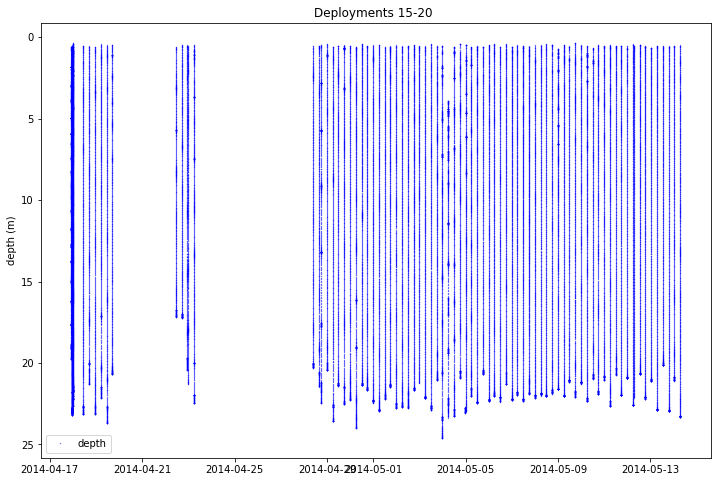

In [139]:
source = ds.source

fig, (ax) = plt.subplots(1,1, figsize=(12,8))
plt.plot(ds['time'],ds['depth'], 'b.', markersize=.5, label='depth')
#plt.plot(ds['time'],ds['spectra'][0], 'g.', markersize=2, label='Air Temperature')
plt.gca().invert_yaxis()
plt.ylabel('depth (m)')
plt.title("Deployments 15-20 ")
plt.legend()
plt.savefig("init_deployments_15-20.png",dpi=500)

Text(0.5, 1.0, 'Deployments 5-9 unchunked ')

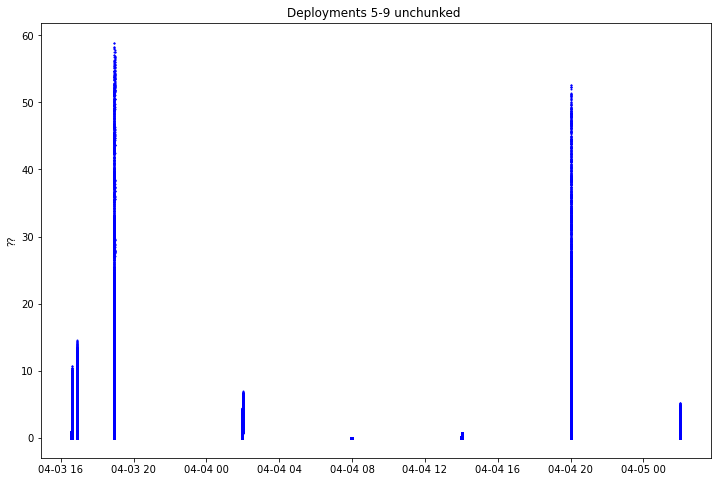

In [352]:
fig, (ax) = plt.subplots(1,1, figsize=(12,8))
plt.plot(ds["time"],ds["spkir_abj_cspp_downwelling_vector"], 'b.', markersize=2)#, label=(wavelengthnm_list))
#plt.plot(ds['time'],ds['spectra'][0], 'g.', markersize=2, label='Air Temperature')
plt.ylabel('??')
plt.title("Deployments 5-9 unchunked ")
#plt.legend();

In [22]:
sns.relplot(data=ds[5:9], x='time', y='depth', hue='spectra', hue_order=wavelengthnm_list, palette = pal, aspect=1.61)
plt.xlabel("time")
plt.ylabel("depth (z)")
plt.title("Spectral Irradiance by Depth for or_inshore 5-9")
#ax.set_xlim([pd.Timestamp('2017-01-01 00:00:00+0000', tz='UTC'), pd.Timestamp('2018-01-01 00:00:00+0000', tz='UTC')])
#cant fuckin figure out how to est x range so doing it by limiting dataset. see above
plt.show()

NameError: name 'ds' is not defined

In [76]:
ds['time']

<xarray.DataArray 'time' (time: 5019)>
array(['2019-04-03T16:34:38.175000064', '2019-04-03T16:34:38.314999808',
       '2019-04-03T16:34:38.444999680', ..., '2019-04-05T02:01:19.472000000',
       '2019-04-05T02:01:19.611999744', '2019-04-05T02:01:19.752000000'],
      dtype='datetime64[ns]')
Coordinates:
    obs      (time) int64 0 1 2 3 4 5 6 7 ... 5012 5013 5014 5015 5016 5017 5018
    lat      (time) float64 dask.array<chunksize=(5019,), meta=np.ndarray>
    lon      (time) float64 dask.array<chunksize=(5019,), meta=np.ndarray>
    depth    (time) float64 dask.array<chunksize=(5019,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2019-04-03T16:34:38.175000064 ... 2019-04-...
Attributes:
    axis:           T
    long_name:      time
    standard_name:  time
    _ChunkSizes:    502

ValueError: Cannot specify both x and y kwargs for line plots.

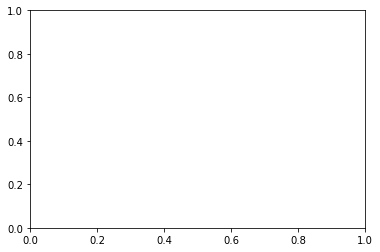

In [79]:
#ic
#https://docs.xarray.dev/en/stable/generated/xarray.plot.line.html 
#trying to hue by spectra dim
#xr.plot.line(ds, x="time", y='spkir_abj_cspp_downwelling_vector', hue = "spectra")

In [ ]:
ds.spkir_abj_cspp_downwelling_vector
#we want to plot this and hue by spectra dimension

xr = ds.spkir_abj_cspp_downwelling_vector
xr

ds_chunked = ds.chunk({'time': 100}) # Used for optimization
ds_chunked

# 3/2 datetime task

In [99]:
# Time Processing Routine
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)

In [102]:
or_inshore_nans["time"]

0        2014-04-17 22:28:00+00:00
1        2014-04-17 22:28:00+00:00
2        2014-04-17 22:28:00+00:00
3        2014-04-17 22:28:00+00:00
4        2014-04-17 22:28:00+00:00
                    ...           
349463   2022-09-27 07:53:00+00:00
349464   2022-09-27 07:53:00+00:00
349465   2022-09-27 07:53:00+00:00
349466   2022-09-27 07:53:00+00:00
349467   2022-09-27 07:53:00+00:00
Name: time, Length: 349468, dtype: datetime64[ns, UTC]

In [101]:
or_inshore_nans["time"] = pd.to_datetime(or_inshore_nans["time"])